<a href="https://colab.research.google.com/github/alessandronascimento/HP_LiBELa/blob/master/Colab/HP_LiBELa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Installing environment
%%capture
!apt-get install libgsl-dev
! git clone https://github.com/alessandronascimento/HP_LiBELa.git
%cd HP_LiBELa/bin
!make

In [5]:
# @title Setting variables

import matplotlib.pyplot as plt
from pyLattice import *
from pyMonteCarlo import *
from pyThermo import *

verbose = False # @param {type:"boolean"}
mc = True # @param {type:"boolean"}
mc_steps = 3000000 # @param {type:"integer"}
single_temp = False # @param {type:"boolean"}
temperature = 30.0 # @param {type:"number"}
alpha = 3.0 # @param {type:"number"}
epsilon = -0.5 # @param {type:"number"}
read_file = False # @param {type:"boolean"}

ti = 25.0 # @param {type:"number"}
tf = 3000.0 # @param {type:"number"}
dt = 25.0 # @param {type:"number"}

polar_epsilon = alpha*epsilon;


print("**********************************************************************");
print("***                                                                ***");
print("***                          HP - LiBELA                           ***");
print("***                                                                ***");
print("***  A minimalist lattice model for ligand binding thermodynamics  ***");
print("***                                                                ***");
print("***         Written by Alessandro S. Nascimento - IFSC/USP         ***");
print("***                       asnascimento@ifsc.usp.br                 ***");
print("***                                                                ***");
print("***                            August/2020                         ***");
print("***                                                                ***");
print("**********************************************************************");

print("***");
print("*** Parameters:");
print("*** Ti = %5.3f" % ti);
print("*** Tf = %5.3f" % tf);
print("*** dT = %5.3f" % dt);
print("*** T  = %5.3f" % temperature);
print("*** <epsilon> = %5.3f" % epsilon);
print("*** <epsilon_polar> = <alpha * epsilon> = %5.3f" % polar_epsilon);
print("***");
print("***                                                                ***");
print("**********************************************************************");


**********************************************************************
***                                                                ***
***                          HP - LiBELA                           ***
***                                                                ***
***  A minimalist lattice model for ligand binding thermodynamics  ***
***                                                                ***
***         Written by Alessandro S. Nascimento - IFSC/USP         ***
***                       asnascimento@ifsc.usp.br                 ***
***                                                                ***
***                            August/2020                         ***
***                                                                ***
**********************************************************************
***
*** Parameters:
*** Ti = 25.000
*** Tf = 3000.000
*** dT = 25.000
*** T  = 30.000
*** <epsilon> = -0.500
*** <epsilon_polar> = <alpha * epsilon>

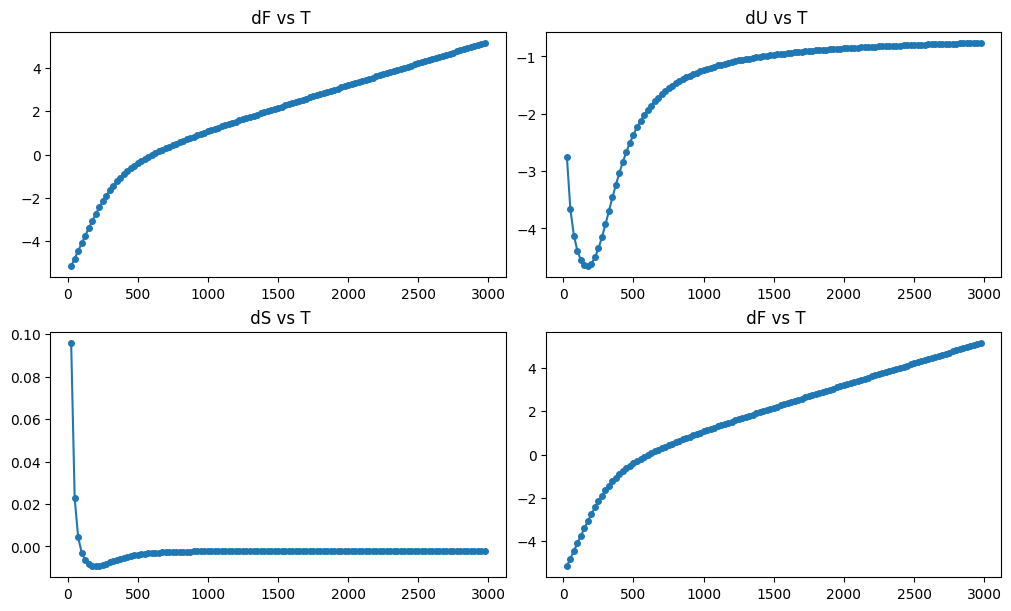

In [3]:
# @title HP Modeling
Binding_Lattice = Lattice(epsilon, polar_epsilon, verbose);

Binding_Lattice.print_line();
Binding_Lattice.print_line();

Binding_Lattice.create_binding_lattice();

Binding_Lattice.print_lattice();
Binding_Lattice.print_ligand();

Binding_Lattice.print_line();
Binding_Lattice.print_line();

if (single_temp):
  ThermoData = Thermo(Binding_Lattice, (0.001985875*temperature));
else:
  ThermoData = Thermo(Binding_Lattice, ti, tf, dt);


Binding_Lattice.print_line();
Binding_Lattice.print_line();

Empty_Lattice = Lattice(epsilon, polar_epsilon, verbose);

Empty_Lattice.print_line();
Empty_Lattice.print_line();

Empty_Lattice.create_empty_binding_lattice();
Empty_Lattice.print_lattice();

Empty_Lattice.print_line();
Empty_Lattice.print_line();

if (single_temp):
  ThermoData2 = Thermo(Empty_Lattice, (0.001985875*temperature));
else:
  ThermoData2 = Thermo(Empty_Lattice, ti, tf, dt);

Empty_Lattice.print_line();
Empty_Lattice.print_line();

Ts = [];
dFs = [];
dUs = [];
dSs = [];

if ( not single_temp):
#  print("#Binding_Data: %10s %10s %10s %10s %10s" % ("Temp(K)", "dF", "dU", "dS", "-TdS"));
  for i in range(len(ThermoData.vlnQ)-1):
    dF = ThermoData.F[i] - ThermoData2.F[i];
    dU = ThermoData.U[i] - ThermoData2.U[i];
    dS = ThermoData.S[i] - ThermoData2.S[i];
#    print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (ThermoData.vt[i], dF, dU, dS, -ThermoData.vt[i]*dS));
    Ts.append(ThermoData.vt[i])
    dFs.append(dF)
    dUs.append(dU)
    dSs.append(dS)

  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)

else:
#  print("#Binding_Data: %10s %10s %10s %10s %10s", "Temp(K)", "dF", "dU", "dS", "-TdS");
  dF = ThermoData.single_F - ThermoData2.single_F;
  dU = ThermoData.single_U - ThermoData2.single_U;
  dS = ThermoData.single_S - ThermoData2.single_S;
#  print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (temperature, dF, dU, dS, -temperature*dS));
  Ts.append(ThermoData.vt[i])
  dFs.append(dF)
  dUs.append(dU)
  dSs.append(dS)
  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)


In [ ]:
# @title Monte Carlo

if (mc):
  print("Staring MC calculation...");
  MC = MonteCarlo(Binding_Lattice, temperature, mc_steps);

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [MC.scores, MC.frac_accept, MC.frac_bound, MC.scores], ['Scores', 'FracAccept','FracBound','Scores']):
    ax.set_title(f' MC Step vs {names}')
    ax.plot(MC.steps, i, 'o', ls='-', ms=4)